## Fastai and Pytorch model built from scratch

This notebook shows image classification using fastai without usg pretrained model

First, import everything needed.

In [1]:
# Python imports
import PIL.Image as Image
import os
import gc
import glob
import pandas as pd
import numpy as np

# PyTorch imports
import torch
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms
import torch.optim as optim



# fastai imports
from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
gc.collect()

46

What is the size of our images?

In [3]:
folder_path = r'/kaggle/input/chess-pieces/all_resized_into_sub_folders_640'

In [4]:
pattern = folder_path + r'/*/*.jpg'

image_path_list = glob.glob(pattern)


# write an check code to confirm that all images in all folders have size (640,640)
image_size_list = []
for image_path in image_path_list:
    size = Image.open(image_path).size
    image_size_list.append(size) 

print(np.unique(np.array(image_size_list)))

[640]


### Fastai first

Now let's build our Datablock

In [5]:
chess_datablock = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                      get_items=get_image_files,
                      get_y=parent_label,
                      splitter=RandomSplitter(seed=900),
                      item_tfms=Resize(100),
                      batch_tfms=aug_transforms(pad_mode='zeros', flip_vert=True, max_lighting=0.5 )
                        )



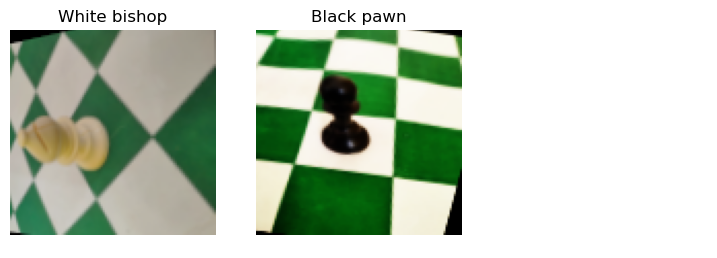

In [6]:
chess_dls = chess_datablock.dataloaders(folder_path, bs=2)
chess_dls.show_batch(nrows=1, ncols=3
                     )

In [7]:
learn_resnet = Learner(chess_dls, models.resnet18(weights=None), loss_func=F.cross_entropy, metrics=accuracy).to_fp16()

SuggestedLRs(valley=0.0014454397605732083)

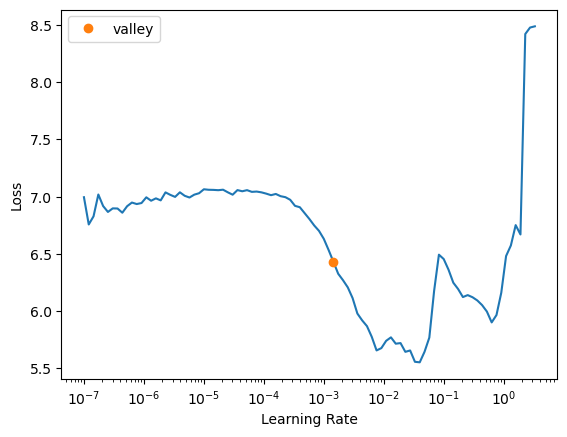

In [8]:
learn_resnet.lr_find()

In [9]:
learn_resnet.fit_one_cycle(10, 0.1)

epoch,train_loss,valid_loss,accuracy,time
0,3.451163,2.941669,0.083333,00:07
1,2.793798,3.248711,0.066667,00:07
2,2.701243,3.343333,0.100000,00:07
3,2.592328,2.652237,0.016667,00:06
4,2.559317,2.614758,0.083333,00:07
5,2.536279,2.585127,0.066667,00:07
6,2.519783,2.565695,0.050000,00:07
7,2.516309,2.558391,0.016667,00:07
8,2.498341,2.549665,0.016667,00:07
9,2.491488,2.549091,0.016667,00:07


In [10]:
interp_resnet = ClassificationInterpretation.from_learner(learn_resnet)

The inaccuracy in this model is definitely from the resnet head, something is wrong there. Find it out.

### Pytorch next

In [11]:

# Define a custom dataset class
class CustomImageDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.file_list = os.listdir(data_dir)
        self.pattern = self.data_dir + r'/*/*.jpg'
        self.image_list = glob.glob(self.pattern)
        
        
    def __len__(self):
        return len(self.image_list)
    
    def __getitem__(self, idx):
        img_name = self.image_list[idx]
        image = Image.open(img_name)
        
        
        
        
        if self.transform:
            image = self.transform(image)
        
        # Extract the label from the filename or directory structure
        # For example, if your data is organized like "class1/image.jpg"
        label = self.file_list.index(os.path.basename(os.path.dirname(img_name)))
        
        return image, label

# Define data transformations (adjust as needed)
data_transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize images to 100x100 pixels
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize if necessary
])

# Create an instance of the custom dataset
data_dir = folder_path
custom_dataset = CustomImageDataset(data_dir, transform=data_transform)

# Create a data loader for batching and shuffling
batch_size = 32




In [12]:
validation_size = int(0.2 * len(custom_dataset))
train_dataset, val_dataset = random_split(custom_dataset, [len(custom_dataset) - validation_size, validation_size])

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Let's build the CNN model using torch

In [14]:

class DeepCNN(nn.Module):
    def __init__(self, num_classes):
        super(DeepCNN, self).__init__()
        
        # Feature extractor layers
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Classifier layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 6 * 6, 512),  # Adjust input size based on 100x100 input images
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Instantiate the model for 12 classes
num_classes = 12
model = DeepCNN(num_classes)


...training

In [15]:


# Define your DeepCNN model
num_classes = 12
model = DeepCNN(num_classes)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust the learning rate as needed

# Set the number of training epochs
num_epochs = 10  # Adjust this as needed

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    
    running_loss = 0.0
    
    # Iterate through your data loader (replace 'train_loader' with your actual data loader)
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, labels)
        
        # Backpropagation and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate the average loss for the epoch
    epoch_loss = running_loss / len(train_dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

print("Training finished!")

# After training, you can evaluate the model on your validation/test dataset
model.eval()  # Set the model to evaluation mode

# Evaluation loop (similar to training loop but without backward pass)
with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in train_dataloader:  # Replace 'validation_loader' with your data loader
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Training Accuracy: {accuracy * 100:.2f}%")

with torch.no_grad():
    correct = 0
    total = 0
    
    for inputs, labels in val_dataloader:  # Replace 'validation_loader' with your data loader
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Val Accuracy: {accuracy * 100:.2f}%")


Epoch [1/10] - Loss: 8.7101
Epoch [2/10] - Loss: 2.8022
Epoch [3/10] - Loss: 1.3816
Epoch [4/10] - Loss: 0.9003
Epoch [5/10] - Loss: 0.7145
Epoch [6/10] - Loss: 0.4348
Epoch [7/10] - Loss: 0.5071
Epoch [8/10] - Loss: 0.3696
Epoch [9/10] - Loss: 0.3100
Epoch [10/10] - Loss: 0.2626
Training finished!
Training Accuracy: 98.33%
Val Accuracy: 63.33%


Clearly overfitting. This is well expected. The background was the same for them all.

In [16]:
# Define your data preprocessing transformations
data_transform = transforms.Compose([
    transforms.Resize((100, 100)),  # Resize to match the model's input size
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize if necessary
])

# Load the input image you want to predict on
image_path = '/kaggle/input/chess-pieces/all_resized_into_sub_folders_640/Black king/resized_1691059574807.jpg'  # Replace with the path to your image
input_image = Image.open(image_path)
input_tensor = data_transform(input_image)  # Apply data transformations

# Ensure the model is in evaluation mode
model.eval()

# Perform the forward pass to get predictions
with torch.no_grad():
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension (batch size of 1)
    outputs = model(input_tensor)

# If your model outputs class probabilities (e.g., for classification tasks), you can apply softmax
# to get the class probabilities
class_probabilities = torch.softmax(outputs, dim=1)

# If your model outputs a single scalar value (e.g., for regression tasks), you can directly use the output
# For example, if the model is a regression model predicting a single value 'output_value'
# output_value = outputs.item()

# If your model predicts class labels (e.g., for classification tasks), you can get the predicted class index
predicted_class_index = torch.argmax(outputs, dim=1).item()

# Print or use the predictions as needed
print("Predicted class index:", predicted_class_index)
print("Class probabilities:", class_probabilities)
print('Class:', os.listdir(data_dir)[predicted_class_index])


Predicted class index: 10
Class probabilities: tensor([[1.1664e-03, 6.5801e-07, 1.1491e-06, 1.2076e-01, 2.9388e-04, 1.1067e-02,
         3.3308e-07, 4.6767e-05, 3.0431e-07, 4.5504e-07, 8.6667e-01, 1.1542e-07]])
Class: Black king
